## Conformalized composite quantile regression

This is a toy example code for conformalized composite quantile regression. The other conformal methods (conformalized quantile regression, conformalized mean regression, distributional conformal prediction) can be implemented by ```others.py``` in repository. 

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from quantile_forest import RandomForestQuantileRegressor
from ccqr.model import CCQRpredictor
import matplotlib.pyplot as plt


### Generate synthetic data

We define a function to generate synthetic data for regression tasks.
The function includes noise from a chi-square distribution and introduces outliers 
with a 5% probability. Note that this is equal to the setting 2 in the paper.


In [2]:

def f(x):
    """
    Generate synthetic data based on a specified function with noise and outliers.

    Parameters:
        x (np.ndarray): Input feature array.

    Returns:
        np.ndarray: Output labels with noise and outliers.
    """
    epsilon = np.random.chisquare(df=3, size=x.shape)  # Noise from chi-square distribution
    y = (1 - x + 2 * x**2) * np.exp(-0.5 * x**2) + (1 + 0.2 * x) / 5 * epsilon
    outliers = (np.random.uniform(0, 1, size=x.shape) < 0.05)  # 5% chance of outliers
    y[outliers] += 15 * np.random.randn(np.sum(outliers))  # Add large noise to outliers
    return y.astype(np.float32)

# Set random seed for reproducibility
np.random.seed(0)

# Generate training and test data

n_train, n_test = 1000, 5000
x_train = np.random.uniform(-4, 4, size=n_train).astype(np.float32).reshape(-1, 1)
y_train = f(x_train).flatten()
x_test = np.random.uniform(-4, 4, size=n_test).astype(np.float32).reshape(-1, 1)
y_test = f(x_test).flatten()

# Split training data into proper training set and calibration set

x_train, x_calib, y_train, y_calib = train_test_split(x_train, y_train, test_size=0.5, random_state=42)

we initialize and train a Random Forest Quantile Regressor as the base model for conformalized composite quantile regression (CCQR). Then we initialize the CCQR predictor with the trained base model and specified parameters. The calibration process adjusts the conformal intervals to achieve the desired coverage.

In [3]:
base_model = RandomForestQuantileRegressor(n_estimators=500, min_samples_leaf=40, max_features=1, random_state=0)
base_model.fit(x_train, y_train)

ccqr = CCQRpredictor(model=base_model, quantiles=[0.05, 0.95], d=0.15, K=9, strategy='score', symmetric=True, adaptive=False)
ccqr.calibrate(x_calib, y_calib)


CCQRpredictor(K=9, alpha=0.10000000000000009, d=0.15,
              model=RandomForestQuantileRegressor(max_features=1,
                                                  min_samples_leaf=40,
                                                  n_estimators=500,
                                                  random_state=0))

Using the calibrated CCQR model, we predict conformal intervals for the test data. The intervals are visualized alongside the test observations.

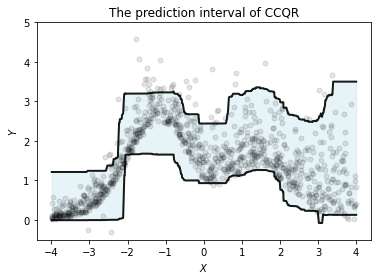

Coverage :  0.904
Interval width :  1.859012339419808


In [4]:
x_test_vis, y_test_vis = x_test[:1000], y_test[:1000]
inds = np.argsort(np.squeeze(x_test_vis))

prediction_intervals = ccqr.predict(x_test_vis)
y_lower, y_upper = prediction_intervals[:, 0], prediction_intervals[:, 1]

plt.figure()
plt.plot(x_test_vis[inds], y_test_vis[inds], 'k.', alpha=0.1, markersize=10, label='Observations')
plt.fill_between(
    x_test_vis[inds].flatten(),
    y_lower[inds],
    y_upper[inds],
    color='lightblue',
    alpha=0.3
)
plt.plot(x_test_vis[inds], y_lower[inds], 'k-', lw=2, alpha=0.9)
plt.plot(x_test_vis[inds], y_upper[inds], 'k-', lw=2, alpha=0.9)
plt.ylim([-0.5, 5])
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title("The prediction interval of CCQR")
plt.show()

print('Coverage : ', np.round(np.mean((y_test_vis >= y_lower) & (y_test_vis <= y_upper)), 4))
print('Interval width : ', np.mean(y_upper - y_lower)) 

Here, we tune the parameter `d` to minimize the average width of the prediction intervals while maintaining the desired coverage level. The best `d` value is selected based on interval width.

In [5]:
best_width, best_d = float('inf'), None
for d in np.arange(0.05, 0.45, 0.05):
    ccqr = CCQRpredictor(model=base_model, quantiles=[0.05, 0.95], d=d, K=9, strategy='score', symmetric=True, adaptive=False)
    ccqr.calibrate(x_calib, y_calib)
    calib_intervals = ccqr.predict(x_calib)
    width = np.mean(calib_intervals[:, 1] - calib_intervals[:, 0])

    if width < best_width:
        best_width, best_d = width, d

print(f'Best d: {best_d}')
print(f'Best interval width: {best_width}')

Best d: 0.3
Best interval width: 1.794907579642629


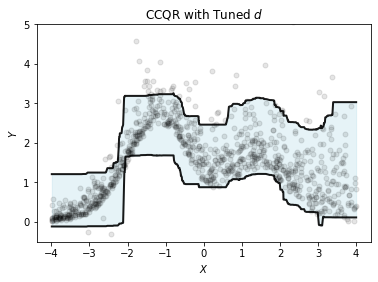

Coverage :  0.901
Interval width :  1.7894693347383408


In [6]:
ccqr = CCQRpredictor(model=base_model, quantiles=[0.05, 0.95], d=best_d, K=9, strategy='score', symmetric=True, adaptive=False)
ccqr.calibrate(x_calib, y_calib)

prediction_intervals = ccqr.predict(x_test_vis)
y_lower, y_upper = prediction_intervals[:, 0], prediction_intervals[:, 1]

plt.figure()
plt.plot(x_test_vis[inds], y_test_vis[inds], 'k.', alpha=0.1, markersize=10, label='Observations')
plt.fill_between(
    x_test_vis[inds].flatten(),
    y_lower[inds],
    y_upper[inds],
    color='lightblue',
    alpha=0.3
)
plt.plot(x_test_vis[inds], y_lower[inds], 'k-', lw=2, alpha=0.9)
plt.plot(x_test_vis[inds], y_upper[inds], 'k-', lw=2, alpha=0.9)
plt.ylim([-0.5, 5])
plt.xlabel('$X$')
plt.ylabel('$Y$')
plt.title("CCQR with Tuned $d$")
plt.show()

print('Coverage : ', np.round(np.mean((y_test_vis >= y_lower) & (y_test_vis <= y_upper)), 4))
print('Interval width : ', np.mean(y_upper - y_lower)) 
